##### AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<center>
    <h1 style = "font-size:48px; font-weight:normal"><b>AI</b>-TECH</style></h1>
    <br>
<br>
<br>
<br>
    <h1 style = "font-size:24px; font-weight:normal">LABORATORIUM 3</style></h1>
    <h1 style = "font-size:24px">z Przetwarzania multimediów w systemach decyzyjnych</style></h1>
    <h1 style = "font-size:24px">Przegląd algorytmów uczących się metryk dystansu dla
danych wizyjnych</style></h1>
    <h1 style = "font-size:24px">Przemysław Rośleń</style></h1>
    <h3 style = "font-size:21px">algorytm straty kontrastowej (contrastive loss)</h3>
    <h3 style =
</center>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
    </body>
    </html>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

<hr>

# Trening sieci algorytmem straty kontrastowej


Algorytm straty kontrastowej w porównaniu do wykorzystywanej implementacji algorytmu starty trójkowej jest nieco szybszy.

In [ ]:
# Import bibliotek
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers     import Input, Dense, Conv2D, Flatten, PReLU, MaxPooling2D, Lambda
from tensorflow.keras.models     import Model
from tensorflow.keras.utils      import to_categorical
from tensorflow.keras            import backend as K
from numpy.linalg                import norm
from sklearn.decomposition       import PCA
from tqdm                        import tqdm

# Nastawy pracy algorytmu:

In [ ]:
# Nastawy algorytmu treningu
learning_rate       = 0.001
batches_per_epoch   = 10
batch_size          = 32
num_training_epochs = 30

# Nastawy algorytmu uczącego się metryk odległości
embedding_length  = 40 # długość wektora reprezentacji
margin            = 1  # ograniczenie na docelową odległość między klastrami punktów
distance_norm     = 'euclidean' # metryka odległości Ln, może być też 1,2, czy np.inf

# Nazwy folderów na dane:
folder_model_weights    = "_weights"
folder_repspace_preview = "_previews"

Odczyt danych z reporytorium TensorFlow Datasets

In [ ]:
# Wykorzystamy zbiór MNIST.
trn_dst, test_dst = tfds.load('mnist', split=['train','test'], shuffle_files=True, as_supervised = True, batch_size=-1)

# Skrypt napisany jest z myślą, że zbiór danych podzielony jest
# na standardowe cztery tablice (X - wzorce wejściowe, Y - etykiety).
trn_X,   trn_Y  = tfds.as_numpy(trn_dst)
test_X,  test_Y = tfds.as_numpy(test_dst)

# Konwertujemy dane wejściowe na format zmiennoprzecinkowy:
trn_X  = trn_X.astype(np.float16)
test_X = test_X.astype(np.float16)

# Pobieramy informację o rozmiarze wejścia.
# (dla MNIST jest to (28, 28, 1))
input_dims = trn_X[0].shape

# Normalizacja danych:

def normalize_dataset(dataset):
    for i in range(len(dataset)):
        dataset[i] = dataset[i]/np.max(np.abs(dataset[i]))
    return dataset

trn_X  = normalize_dataset(trn_X)
test_X = normalize_dataset(test_X)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Definicja pojedynczej gałęzi sieci.

Teoretycznie w kontekście algorytmów uczących się metryk dystansu mówi się o sieci syjamskiej, jednak definiowanie jej struktury wprost w kodzie jest nadmiarowe.

W praktyce definiuje się strukturę tylko jednej z odnóg sieci - druga jest identyczna, więc ta pojedyncza sieć jest w procesie treningu uruchamiana dwa razy.

Moduł obliczający odległość na podstawie dwóch reprezentacji zrealizowany jest w funkcji straty zdefiniowanej w dalszej części skryptu


In [ ]:
network_input = Input(shape=input_dims, name="left_input")
x = Conv2D(8,(5,5),  activation=PReLU(), padding='same')(network_input)
x = Conv2D(8,(5,5),  activation=PReLU(), padding='same')(x)
x = Flatten()(x)
x = Dense(128)(x)
embedding_vector = Dense(embedding_length, activation=None)(x)
encoder_model    = Model(inputs=network_input, outputs=embedding_vector)

print("Struktura kodera:")
encoder_model.summary()
print()


Struktura kodera:
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 left_input (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 8)         6480      
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 8)         7880      
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               802944    
                                                                 
 dense_5 (Dense)             (None, 40)                5160      
                                                                 
Total params: 822464 (3.14 MB)
Trainable 

# Definicje funkcji składowych algorytmu triplet loss i trening

In [ ]:
def contrastive_loss_function(pattern_pos_A, pattern_pos_B, pattern_neg_A, pattern_neg_B, distance_norm='euclidean', margin=1):
    distance_pos   = tf.norm(pattern_pos_B - pattern_pos_A, ord=distance_norm, axis=1)
    distance_neg   = tf.norm(pattern_neg_B - pattern_neg_A, ord=distance_norm, axis=1)
    partial_losses = distance_pos + tf.math.maximum(0, margin - distance_neg)
    loss_value     = tf.math.reduce_mean(partial_losses)
    return loss_value

def mine_pairs(trn_X, trn_Y):
    classes_available = np.unique(trn_Y)
    positive_class    = np.random.choice(classes_available)

    positive_class_examples = trn_X[trn_Y==positive_class]
    negative_class_examples = trn_X[trn_Y!=positive_class]

    positive_pattern_idx    = np.random.choice(len(positive_class_examples),2,replace=False)

    negative_pattern_idx  = np.random.choice(len(negative_class_examples),2,replace=False)

    pattern_pos_A = positive_class_examples[positive_pattern_idx[0]]
    pattern_pos_B = positive_class_examples[positive_pattern_idx[1]]
    pattern_neg_A = negative_class_examples[negative_pattern_idx[0]]
    pattern_neg_B = negative_class_examples[negative_pattern_idx[1]]

    return (pattern_pos_A, pattern_pos_B, pattern_neg_A, pattern_neg_B)

# Przygotowanie środowiska pracy:
if not os.path.isdir(folder_repspace_preview): os.mkdir(folder_repspace_preview)
if not os.path.isdir(folder_model_weights):    os.mkdir(folder_model_weights)

# Jeśli w folderze z wizualizacjami pozostały pliki po poprzednim uruchomieniu skryptu, to
# te pliki usuwamy.
for fname in os.listdir(folder_repspace_preview):
    fpath = os.path.join(folder_repspace_preview, fname)
    os.remove(fpath)

# Opcjonalnie - można załadować wagi modelu:
if os.path.isfile(os.path.join(folder_model_weights,'model_weights.h5')):
    try:
        encoder_model.load_weights(os.path.join(folder_model_weights,"model_weights.h5"))
    except ValueError as e:
        print()
        print("uwaga: nie udało się wczytać poprzednich wag modelu (np. dlatego, że zmieniła się struktura sieci, lub z innego powodu)")
        print("opis błędu odczytu:")
        print(e)
        print()

# Na koniec rozpoczynamy właściwy trening sieci:
epoch_number  = 1
optimizer     = tf.keras.optimizers.Adam(learning_rate)

print("trening sieci neuronowej algorytmem contrastive loss został rozpoczęty")
print()

# trenujemy, aż nie otrzymamy sygnału wstrzymania z klawiatury (ctrl+c):
batch_matrix_shape = tuple([batch_size] + list(input_dims))

for epoch_number in range(1,num_training_epochs+1):

    # --------------------------------------------------------
    # właściwy algorytm treningu sieci:

    print(f"epoka: {epoch_number}")

    # Korzystamy z własnego zdefiniowania algorytmu treningu, stąd musimy posłuzyć się kontekstem GradientTape:
    with tf.GradientTape() as tape:
        accumulated_loss = 0

        # Dla każdej grupy danych:
        for batch_idx in tqdm(range(batches_per_epoch)):

            pattern_pos_A_mtx = np.zeros(batch_matrix_shape)
            pattern_pos_B_mtx = np.zeros(batch_matrix_shape)
            pattern_neg_A_mtx = np.zeros(batch_matrix_shape)
            pattern_neg_B_mtx = np.zeros(batch_matrix_shape)

            for i in range(batch_size):
                pattern_pos_A, pattern_pos_B, pattern_neg_A, pattern_neg_B = mine_pairs(trn_X, trn_Y)
                pattern_pos_A_mtx[i,::] = pattern_pos_A
                pattern_pos_B_mtx[i,::] = pattern_pos_B
                pattern_neg_A_mtx[i,::] = pattern_neg_A
                pattern_neg_B_mtx[i,::] = pattern_neg_B

            # Oblicz reprezentacje wyłonionych przykładów:
            representations_pos_A = encoder_model(pattern_pos_A_mtx, training=True)
            representations_pos_B = encoder_model(pattern_pos_B_mtx, training=True)
            representations_neg_A = encoder_model(pattern_neg_A_mtx, training=True)
            representations_neg_B = encoder_model(pattern_neg_B_mtx, training=True)

            # Oblicz wartość funkcji straty i dodaj ją do zmiennej, która na koniec wykonania wewnętrznej pętli będzie zawierać
            # średnią wartość straty dla całej epoki:
            loss_value = contrastive_loss_function(representations_pos_A, representations_pos_B, representations_neg_A, representations_neg_B, distance_norm=distance_norm, margin=margin)
            accumulated_loss += loss_value*tf.constant(1./batches_per_epoch)

    # Wylicz gradienty na podstawie funkcji straty:
    grads = tape.gradient(accumulated_loss, encoder_model.trainable_weights)

    # Zaaplikuj poprawki do wag sieci za pomocą algorytmu wstecznej propagacji błędów
    optimizer.apply_gradients(zip(grads, encoder_model.trainable_weights))

    # --------------------------------------------------------
    # wizualizacja, zapis wag i raportowanie postępów
    info_text = f"wartość straty kontrastowej (contrastive loss): {accumulated_loss}"
    print(info_text)
    print()

    # Zapis wag do późniejszego użycia:
    encoder_model.save_weights(os.path.join(folder_model_weights,'model_weights.h5'),save_format="h5")

    # Wizualizacja przestrzeni reprezentacji za pomocą PCA, jest to konieczne,
    # bo wizualizacja ma tylko 2 wymiary, a reprezentacje typowo mają wymiarów
    # znacznie więcej.
    test_embeddings = encoder_model(test_X)
    pca             = PCA(n_components=2, svd_solver='full')
    reduced         = pca.fit_transform(test_embeddings)

    # Rysujemy obliczoną wcześniej wizualizację i zapisujemy na dysk:
    plt.figure(figsize=(16,9))
    for class_name in np.unique(test_Y):
        mask = test_Y == class_name
        plt.scatter(reduced[mask,0],reduced[mask,1], label=class_name, s=10)
    plt.legend()
    plt.title(info_text)
    plt.grid()

    epoch_num_str = str(epoch_number).zfill(5)
    plt.savefig(os.path.join(folder_repspace_preview,f"preview_{epoch_num_str}.png"))
    plt.close()



uwaga: nie udało się wczytać poprzednich wag modelu (np. dlatego, że zmieniła się struktura sieci, lub z innego powodu)
opis błędu odczytu:
Cannot assign value to variable ' dense_5/kernel:0': Shape mismatch.The variable shape (128, 40), and the assigned value shape (128, 20) are incompatible.

trening sieci neuronowej algorytmem contrastive loss został rozpoczęty

epoka: 1


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


wartość straty kontrastowej (contrastive loss): 0.813952624797821

epoka: 2


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


wartość straty kontrastowej (contrastive loss): 0.7657326459884644

epoka: 3


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


wartość straty kontrastowej (contrastive loss): 0.759486973285675

epoka: 4


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


wartość straty kontrastowej (contrastive loss): 0.7258226275444031

epoka: 5


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


wartość straty kontrastowej (contrastive loss): 0.7015467882156372

epoka: 6


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


wartość straty kontrastowej (contrastive loss): 0.7201894521713257

epoka: 7


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


wartość straty kontrastowej (contrastive loss): 0.7239395976066589

epoka: 8


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


wartość straty kontrastowej (contrastive loss): 0.6723189353942871

epoka: 9


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


wartość straty kontrastowej (contrastive loss): 0.680608868598938

epoka: 10


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


wartość straty kontrastowej (contrastive loss): 0.6428192853927612

epoka: 11


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


wartość straty kontrastowej (contrastive loss): 0.6451772451400757

epoka: 12


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


wartość straty kontrastowej (contrastive loss): 0.642756998538971

epoka: 13


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


wartość straty kontrastowej (contrastive loss): 0.6222162842750549

epoka: 14


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


wartość straty kontrastowej (contrastive loss): 0.610562264919281

epoka: 15


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


wartość straty kontrastowej (contrastive loss): 0.6041134595870972

epoka: 16


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


wartość straty kontrastowej (contrastive loss): 0.5981763601303101

epoka: 17


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


wartość straty kontrastowej (contrastive loss): 0.6123157143592834

epoka: 18


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


wartość straty kontrastowej (contrastive loss): 0.594978392124176

epoka: 19


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


wartość straty kontrastowej (contrastive loss): 0.605266809463501

epoka: 20


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


wartość straty kontrastowej (contrastive loss): 0.5784622430801392

epoka: 21


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


wartość straty kontrastowej (contrastive loss): 0.5537079572677612

epoka: 22


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


wartość straty kontrastowej (contrastive loss): 0.5741972923278809

epoka: 23


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


wartość straty kontrastowej (contrastive loss): 0.594052791595459

epoka: 24


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


wartość straty kontrastowej (contrastive loss): 0.5406621098518372

epoka: 25


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


wartość straty kontrastowej (contrastive loss): 0.5789503455162048

epoka: 26


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


wartość straty kontrastowej (contrastive loss): 0.5527570843696594

epoka: 27


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


wartość straty kontrastowej (contrastive loss): 0.5359048247337341

epoka: 28


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


wartość straty kontrastowej (contrastive loss): 0.5830961465835571

epoka: 29


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


wartość straty kontrastowej (contrastive loss): 0.5356432199478149

epoka: 30


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


wartość straty kontrastowej (contrastive loss): 0.5426195859909058



**Zadanie 4**

In [ ]:
def find_similar_and_different(mnist_example, model, mnist_set, mnist_vector_set, distance_norm):
  vector_example = model(mnist_example.reshape(1, 28, 28, 1))
  distances_indexes = []
  data_type = [('distance', float), ('index', int)]
  for index, vector in enumerate(mnist_vector_set):
    distance = np.linalg.norm(vector_example - vector, ord=distance_norm)
    distances_indexes.append((distance, index))
  distances_indexes = np.array(distances_indexes, dtype=data_type)
  distances_indexes = np.sort(distances_indexes, order='distance')
  indexes = distances_indexes['index']
  similar = mnist_set[indexes[1:5]]
  different = mnist_set[indexes[-5:-1]]
  return [similar, different]

mnist_example = test_X[1]
model = encoder_model
mnist_set = test_X
mnist_vector_set = encoder_model(test_X)

[similar, different] = find_similar_and_different(mnist_example, model, mnist_set, mnist_vector_set, distance_norm)

Image


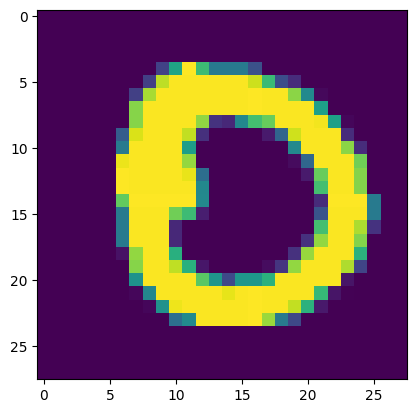

In [ ]:
plt.figure()
print('Image')
plt.imshow(mnist_example)
plt.show()

Similar


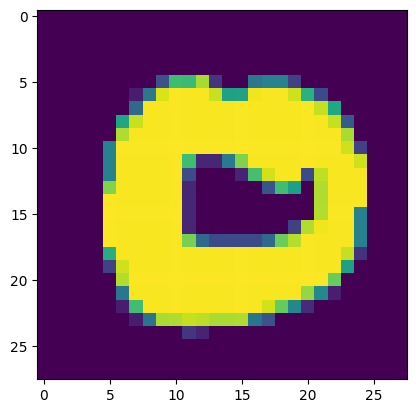

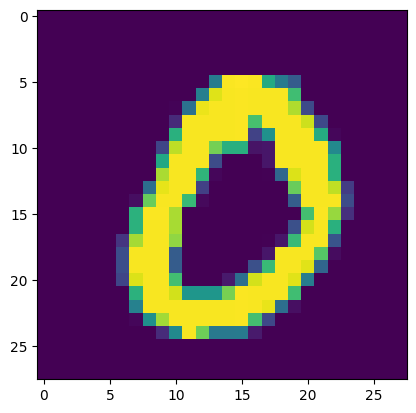

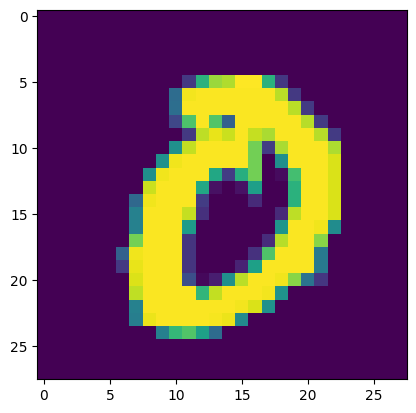

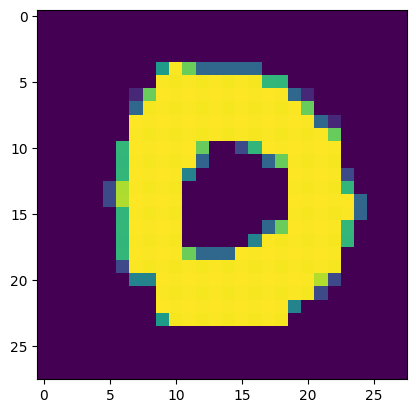

In [ ]:
plt.figure()
print('Similar')
for image in similar:
  plt.imshow(image)
  plt.show()

Different


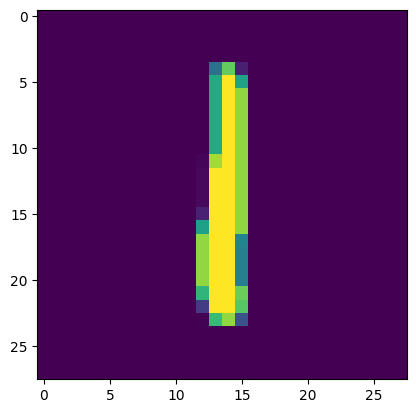

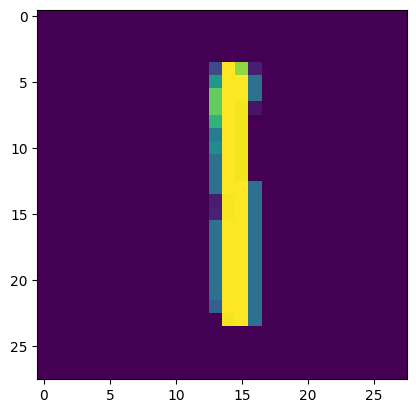

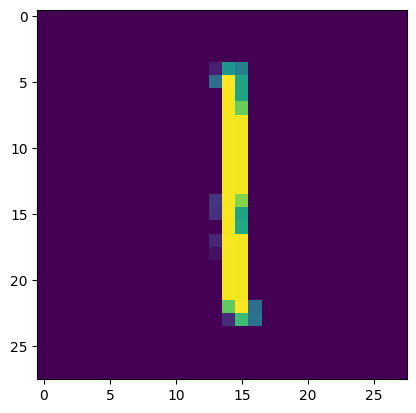

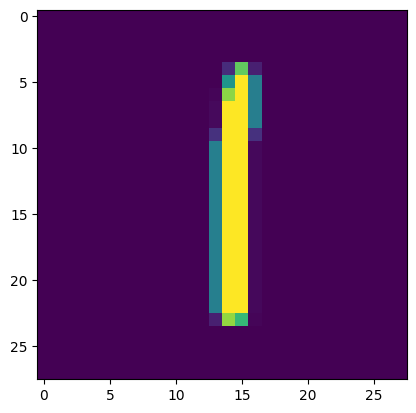

In [ ]:
plt.figure()
print('Different')
for image in different:
  plt.imshow(image)
  plt.show()